In [1]:
%cd '/home/naodell/work/CMS/z_plus_jpsi'
%run scripts/plot.py

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
from scipy.stats import gaussian_kde
#from scripts.weighted_kde import gaussian_kde

matplotlib.style.use('default')
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)


/home/naodell/work/CMS/z_plus_jpsi


Loading dataframes: 100%|███████████████| 20.0/20.0 [00:01<00:00, 6.11it/s]


In [2]:
output_path = '/home/naodell/work/CMS/z_plus_jpsi/plots/2D_test'
#features = ['dilepton2_mass', 'tetralepton_mass']
features = ['dilepton1_mass', 'dilepton2_mass']

dm = data_manager
pt.make_directory(output_path)
dataframes = dm._dataframes  

lut_datasets = dm._lut_datasets
lut_entry_x = dm._lut_features.loc[features[0]]
lut_entry_y = dm._lut_features.loc[features[1]]

## Get the background data
bg_x, weights = pt.get_data_and_weights(dataframes, features[0], bg_labels, lut_entry_x.condition)
bg_y, weights = pt.get_data_and_weights(dataframes, features[1], bg_labels, lut_entry_y.condition)
bg_x = np.concatenate(bg_x)
bg_y = np.concatenate(bg_y)
weights = np.concatenate(weights)

## Get the data data
#mask = '{0} and {1}'.format(lut_entry_x.condition, lut_entry_y.condition)
df_data = dataframes['data']
data_x = df_data[features[0]]
data_y = df_data[features[1]]

In [4]:
# Prepare grid for KDE
bw = 0.15
n_data = int(1e4)
xmin, xmax = lut_entry_x.xmin, lut_entry_x.xmax
ymin, ymax = lut_entry_y.xmin, lut_entry_y.xmax
xx, yy     = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions  = np.stack([xx.ravel(), yy.ravel()])

# Wrap these guys
# Peform the KDE on the background
vals_bg    = np.stack([bg_x[:n_data], bg_y[:n_data]])
weights    = weights[:n_data]
#kernel_bg  = gaussian_kde(vals_bg, bw_method=bw, weights=weights)
kernel_bg  = gaussian_kde(vals_bg, bw_method=bw)
f_bg       = np.reshape(kernel_bg(positions).T, xx.shape)

# Peform the KDE on the data
vals_data   = np.vstack([data_x, data_y])
kernel_data = gaussian_kde(vals_data, bw_method=bw)
f_data     = np.reshape(kernel_data(positions).T, xx.shape)

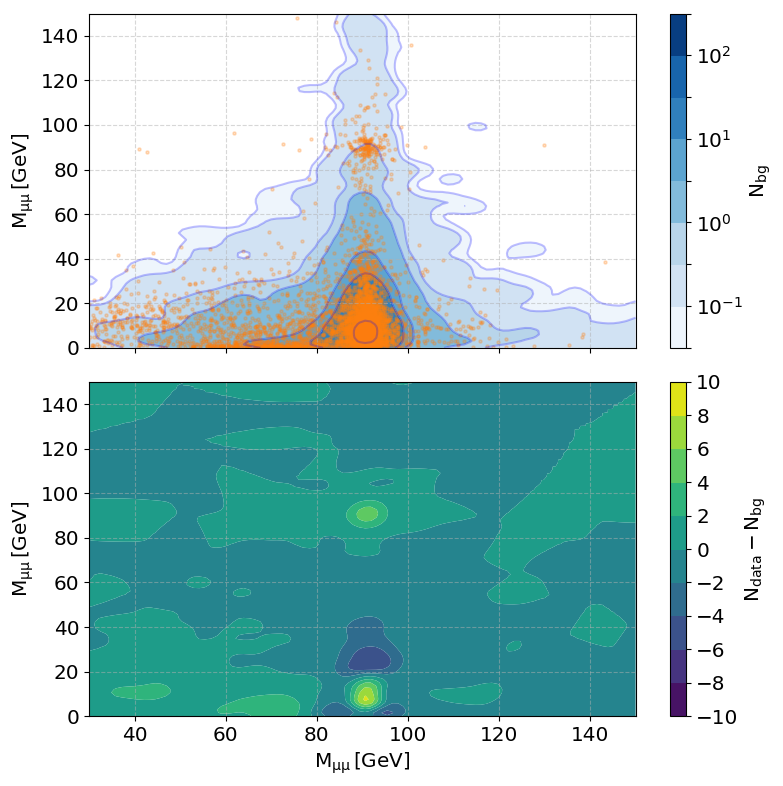

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, tight_layout=True)

# scale KDEs to predict number of events
f_bg   *= 1e4/f_bg.sum()
f_data *= 1e4/f_data.sum()

from matplotlib.colors import LogNorm
# Contour plots of bg kde
lvls = [0.05, 0.1, 0.5, 1., 5, 10., 50, 100., 500.]
bg_contours = axes[0].contourf(xx, yy, f_bg, cmap='Blues', antialiased=True, levels=lvls, norm=LogNorm())
axes[0].contour(xx, yy, f_bg, colors='b', alpha=0.25, antialiased=True, levels=lvls)

# Scatter plot of data points
axes[0].scatter(vals_data[0][:5000], vals_data[1][:5000], marker='o', s=5, c='C1', alpha=0.25)

# Label plot
#ax.clabel(cset, inline=1, fontsize=10)
axes[0].set_xlim(xmin, xmax)
axes[0].set_ylim(ymin, ymax)
axes[0].set_ylabel(f'$\sf {lut_entry_y.x_label}$')
axes[0].grid(alpha=0.5, ls='--')
plt.colorbar(bg_contours, ax=axes[0], label='$\sf N_{bg}$')

# Contour plots of difference of data and bg KDEs
diff = f_data - f_bg
lvls = np.linspace(-10, 10, 11)
diff_contours = axes[1].contourf(xx, yy, diff, cmap='viridis', levels=lvls, antialiased=True)

# Label plot
#ax.clabel(cset, inline=1, fontsize=10)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylim(ymin, ymax)
axes[1].set_xlabel(f'$\sf {lut_entry_x.x_label}$')
axes[1].set_ylabel(f'$\sf {lut_entry_y.x_label}$')
axes[1].grid(alpha=0.5, ls='--')
plt.colorbar(diff_contours, ax=axes[1], label='$\sf N_{data} - N_{bg}$', ticks=lvls)

plt.show()